# NL-to-SQL Evaluation over Spider

```
Copyright 2024 Kyle Luoma

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
from collections import defaultdict
import src.util.load_consolidated_results as lcr

In [2]:
td_dict = {True: 1, False: 0}
nat_cat_dict = {'NATIVE': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'N4': 4}
# cat_label_dict = {'N1': 'Most', 'N2': 'Medium', 'N3': 'Least', 'NATIVE': 'Native', 'combined': 'Combined'}
cat_label_dict = {
    'N1': 'Regular', 
    'N2': 'Low', 
    'N3': 'Least', 
    'N4': 'Regular-Improved',
    'NATIVE': 'Native Schema', 
    'combined': 'Combined'}

In [3]:
loader = lcr.ConsolidatedResultsLoader()
annotation_df = loader.get_joined_dataframes()
annotation_df = annotation_df.query("'spider' in database")

In [4]:
annotation_df.database.unique()

array(['spider'], dtype=object)

In [5]:
annotation_df.shape[0]

8272

In [6]:
annotation_df['exclude_from_linking'] = annotation_df.apply(
    lambda row: True if row.f1 == 0 and row.extra_tables == 'set()' and row.extra_columns == 'set()' else False,
    axis=1
)
annotation_df['exclude_from_linking'].describe()

count      8272
unique        2
top       False
freq       8225
Name: exclude_from_linking, dtype: object

In [7]:
annotation_df['naturalness_label'] = annotation_df.apply(
    lambda row: cat_label_dict[row.naturalness],
    axis=1
)

In [8]:
comb_weights={'N1': 1, 'N2': .5, 'N3': 0}

annotation_df['Qg_combined_nat'] = annotation_df.apply(
    lambda row: (
        (row.Qg_identifier_N1_pct)*comb_weights['N1'] +
        (row.Qg_identifier_N2_pct)*comb_weights['N2'] +
        (row.Qg_identifier_N3_pct)*comb_weights['N3']
        ),
    axis=1
)

annotation_df['schema_combined_nat'] = annotation_df.apply(
    lambda row: (
        (row.schema_identifier_N1_pct)*comb_weights['N1'] +
        (row.schema_identifier_N2_pct)*comb_weights['N2'] +
        (row.schema_identifier_N3_pct)*comb_weights['N3']
        ),
    axis=1
)

In [9]:
annotation_df["model_abbreviated"] = annotation_df.model.apply(
    lambda x:{
        "gpt-4o": "GPT-4o-ZS",
        "gpt-3.5": "GPT-3.5-ZS"
    }[x]
)

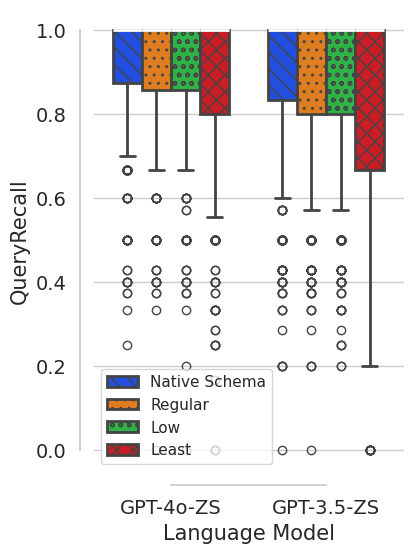

In [10]:
plt.figure(figsize=(4, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    data=annotation_df.query(
        "exclude_from_linking == False"
        ).sort_values(by=['naturalness_order', 'model_order']),
    # hue='col_naturalness_modifier',
    # order=['NATIVE', 'N1', 'N2', 'N3'],
    # x='col_naturalness_modifier',
    x='model_abbreviated',
    y='recall',
    # palette=["m", "g", 'b', 'orange'],
    palette='bright',
    hue = 'naturalness_label',
    linewidth=2,
    width=.75,
    medianprops={'color': 'white', 'ls': '-', 'lw': 2}
    )
hatches = ['\\\\', '..', 'oo', 'xx']
for i, thisbar in enumerate(ax.patches):
    if i in [0, 1]:
        thisbar.set_hatch(hatches[0])
    elif i in [2, 3]:
        thisbar.set_hatch(hatches[1])
    elif i in [4, 5]:
        thisbar.set_hatch(hatches[2])
    else:
        thisbar.set_hatch(hatches[3])
handles, labels = ax.get_legend_handles_labels()
for handle, hatch in zip(handles, hatches):
    handle.set_hatch(hatch)

sns.despine(offset=10, trim=True)
plt.legend(loc='lower left')
plt.ylabel('QueryRecall', size=15)
plt.xlabel('Language Model', size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_yticklabels(ax.get_yticklabels(), size=14)
ax.figure.savefig("./figure_output/spider-queryrecall-boxplot.pdf", dpi=300)

/tmp/ipykernel_23328/131756282.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_23328/131756282.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


<Figure size 400x600 with 0 Axes>

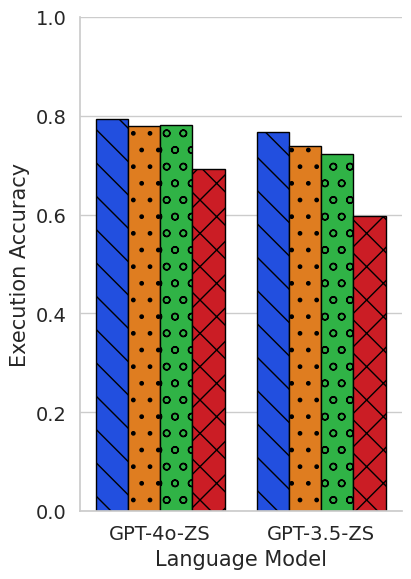

In [11]:
plt.figure(figsize=(4, 6))
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=annotation_df.sort_values(
            by=["naturalness_order", "model_order"]
        ).query(
            "manual_match >= 0"
        ),
    x='model_abbreviated',
    y='manual_match',
    kind='bar',
    # palette=["m", "g", 'b', 'orange'],
    palette='bright',
    hue='naturalness_label',
    legend=False,
    edgecolor="black",
    aspect=1,
    errorbar=None,
    )
g.set(ylim=(0, 1))
g.fig.set_size_inches(4,6)
g.set_axis_labels('Language Model', 'Execution Accuracy', size=14)
hatches = ['\\', '.', 'o', 'x']

for ax in g.axes.flat:
    ax.tick_params(labelsize=18)
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.set_title(ax.get_title(), fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

for j, f in enumerate(g.axes.flat):
    for i, thisbar in enumerate(f.patches):
        if i < 2:
            thisbar.set_hatch(hatches[0])
        elif i < 4:
            thisbar.set_hatch(hatches[1])
        elif i < 6:
            thisbar.set_hatch(hatches[2])
        else:
            thisbar.set_hatch(hatches[3])
g.savefig("./figure_output/spider-executionaccuracy-barplot.pdf", dpi=300)

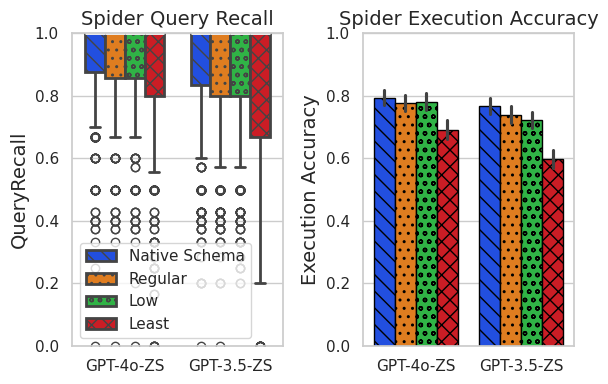

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
hatches = ['\\\\', '..', 'oo', 'xx']
# Copy the existing ax and g plots to the new subplots
sns.boxplot(
    data=annotation_df.query(
        "exclude_from_linking == False"
        ).sort_values(by=['naturalness_order', 'model_order']),
    x='model_abbreviated',
    y='recall',
    palette='bright',
    hue='naturalness_label',
    linewidth=2,
    width=.75,
    medianprops={'color': 'white', 'ls': '-', 'lw': 2},
    ax=ax1,
    legend=True
)
ax1.set_title('Spider Query Recall', size=14)
ax1.set_xlabel('', size=14)
ax1.set_ylabel('QueryRecall', size=14)
ax1.set(ylim=(0,1))
sns.barplot(
    data=annotation_df.sort_values(
            by=["naturalness_order", "model_order"]
        ).query(
            "manual_match >= 0"
        ),
    x='model_abbreviated',
    y='manual_match',
    palette='bright',
    hue='naturalness_label',
    edgecolor="black",
    ax=ax2,
    legend=False
)
ax2.set_title('Spider Execution Accuracy', size=14)
ax2.set_xlabel('', size=14)
ax2.set_ylabel('Execution Accuracy', size=14)
ax2.set(ylim=(0,1))

handles, labels = ax1.get_legend_handles_labels()
for handle, hatch in zip(handles, hatches):
    handle.set_hatch(hatch)
ax1.legend(handles=handles, labels=labels, loc='lower left')

for i, thisbar in enumerate(ax1.patches):
    if i < 2:
        thisbar.set_hatch(hatches[0])
    elif i < 4:
        thisbar.set_hatch(hatches[1])
    elif i < 6:
        thisbar.set_hatch(hatches[2])
    else:
        thisbar.set_hatch(hatches[3])

for i, thisbar in enumerate(ax2.patches):
    if i < 2:
        thisbar.set_hatch(hatches[0])
    elif i < 4:
        thisbar.set_hatch(hatches[1])
    elif i < 6:
        thisbar.set_hatch(hatches[2])
    else:
        thisbar.set_hatch(hatches[3])

plt.tight_layout()
plt.show()
fig.savefig("./figure_output/spider-combined-results.pdf", dpi=300)

In [13]:
for measurement in ['recall', 'precision', 'f1', 'manual_match']:
    print(f"----------{measurement}----------")
    models = []
    native_k_tau_stat = []
    native_k_tau_p = []
    native_n = []
    modified_k_tau_stat = []
    modified_k_tau_p = []
    modified_n = []
    for model in annotation_df.sort_values(by='model_order').model.unique():
        df_query = f"model == '{model}'"
        df_query_native = "and naturalness == 'NATIVE'"
        if measurement != 'manual_match':
            df_query_exclude = 'and exclude_from_linking == False'
        else:
            df_query_exclude = ''
        print(f"-----{model}-----")
        model_df = annotation_df.query(f'{df_query} {df_query_native} {df_query_exclude}')
        kendall_res = stats.kendalltau(model_df.Qg_combined_nat, model_df[measurement])
        models.append(model)
        native_k_tau_stat.append(kendall_res.statistic)
        native_k_tau_p.append(kendall_res.pvalue)
        native_n.append(model_df.shape[0])

        model_df = annotation_df.query(f"{df_query} {df_query_exclude}")
        kendall_res = stats.kendalltau(model_df.Qg_combined_nat, model_df[measurement])
        modified_k_tau_stat.append(kendall_res.statistic)
        modified_k_tau_p.append(kendall_res.pvalue)
        modified_n.append(model_df.shape[0])

        print("Native:")
        k_tau_df_native = pd.DataFrame({
            'Model': models,
            'Kendall-Tau': native_k_tau_stat,
            'P Value': native_k_tau_p,
            'n': native_n,
        })
        print(k_tau_df_native)

        print("All DBs:")        
        k_tau_df_all = pd.DataFrame({
            'Model': models,
            'Kendall-Tau': modified_k_tau_stat,
            'P Value': modified_k_tau_p,
            'n': modified_n
        })
        print(k_tau_df_all)

----------recall----------
-----gpt-4o-----
Native:
    Model  Kendall-Tau   P Value     n
0  gpt-4o      0.11727  0.000028  1023
All DBs:
    Model  Kendall-Tau       P Value     n
0  gpt-4o     0.081288  2.598588e-09  4095
-----gpt-3.5-----
Native:
     Model  Kendall-Tau       P Value     n
0   gpt-4o     0.117270  2.822304e-05  1023
1  gpt-3.5     0.150885  4.685196e-08  1033
All DBs:
     Model  Kendall-Tau       P Value     n
0   gpt-4o     0.081288  2.598588e-09  4095
1  gpt-3.5     0.118453  1.078544e-18  4130
----------precision----------
-----gpt-4o-----
Native:
    Model  Kendall-Tau   P Value     n
0  gpt-4o     0.096152  0.000551  1023
All DBs:
    Model  Kendall-Tau       P Value     n
0  gpt-4o     0.071863  1.240782e-07  4095
-----gpt-3.5-----
Native:
     Model  Kendall-Tau   P Value     n
0   gpt-4o     0.096152  0.000551  1023
1  gpt-3.5     0.055483  0.045750  1033
All DBs:
     Model  Kendall-Tau       P Value     n
0   gpt-4o     0.071863  1.240782e-07  4095
1  gp